In [1]:
%run set_theme.ipynb

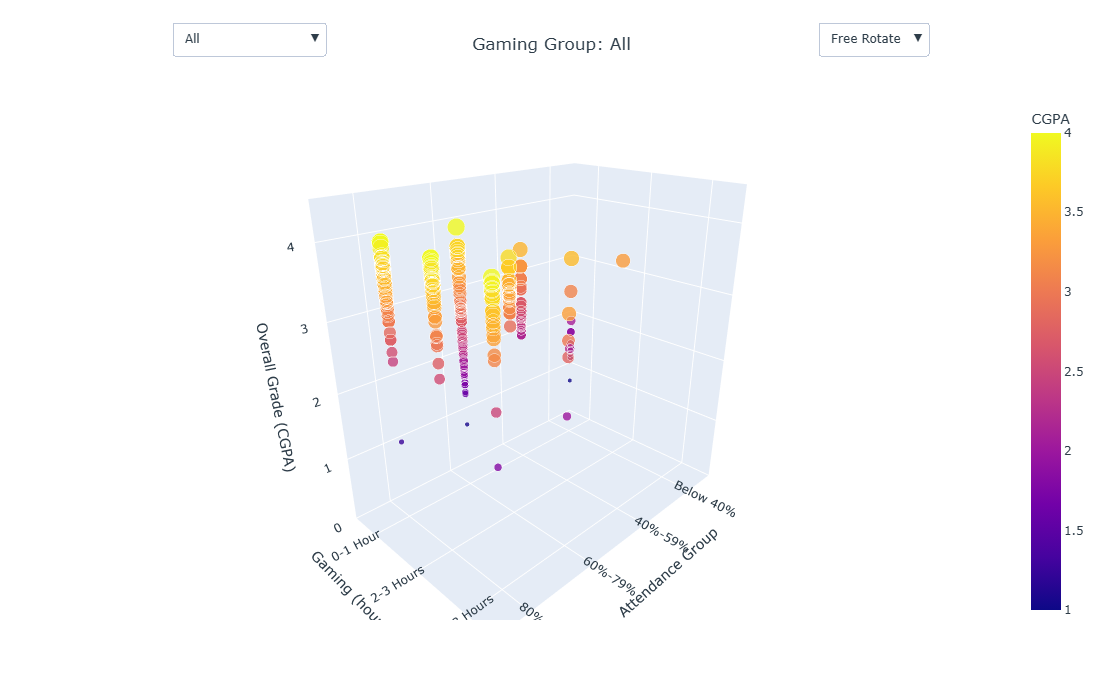

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Hieronder laad je de datasets in
df1 = pd.read_csv("StudentPerformanceFactors.csv")
df2 = pd.read_csv("gameandgrade.csv")
df3 = pd.read_csv("ResearchInformation3.csv")
import pandas as pd
import plotly.graph_objects as go

# Load your datasets
df1 = pd.read_csv("StudentPerformanceFactors.csv")
df2 = pd.read_csv("gameandgrade.csv")
df3 = pd.read_csv("ResearchInformation3.csv")

# Select dataset with required columns
for df_candidate in [df1, df2, df3]:
    if {"Gaming", "Attendance", "Overall"}.issubset(df_candidate.columns):
        df = df_candidate
        break
else:
    raise ValueError("No dataset contains all required columns.")

# Clean and prepare the data
df_clean = df[["Gaming", "Attendance", "Overall"]].dropna().copy()

gaming_order = ["More than 3 Hours", "2-3 Hours", "0-1 Hour"]
attendance_order = ["Below 40%", "40%-59%", "60%-79%", "80%-100%"]

df_clean["Gaming"] = pd.Categorical(df_clean["Gaming"], categories=gaming_order, ordered=True)
df_clean["Attendance"] = pd.Categorical(df_clean["Attendance"], categories=attendance_order, ordered=True)

# Map categories to numeric values
df_clean["Gaming_num"] = df_clean["Gaming"].cat.codes
df_clean["Attendance_num"] = df_clean["Attendance"].cat.codes

# Create main trace (all data)
trace_all = go.Scatter3d(
    x=df_clean["Attendance_num"],
    y=df_clean["Gaming_num"],
    z=df_clean["Overall"],
    mode='markers',
    name="All",
    visible=True,
    marker=dict(
        size=df_clean["Overall"] * 5,
        color=df_clean["Overall"],
        colorscale="Plasma",
        colorbar={"title": "CGPA"},
        opacity=0.8
    ),
    text=[f"Attendance: {a}<br>Gaming: {g}<br>CGPA: {c:.2f}" 
          for a, g, c in zip(df_clean["Attendance"], df_clean["Gaming"], df_clean["Overall"])],
    hoverinfo='text'
)

# Individual group traces
group_traces = []
for group in gaming_order:
    group_data = df_clean[df_clean["Gaming"] == group]
    trace = go.Scatter3d(
        x=group_data["Attendance_num"],
        y=group_data["Gaming_num"],
        z=group_data["Overall"],
        mode='markers',
        name=group,
        visible=False,
        marker=dict(
            size=group_data["Overall"] * 5,
            color=group_data["Overall"],
            colorscale="Plasma",
            colorbar={"title": "CGPA"},
            opacity=0.8
        ),
        text=[f"Attendance: {a}<br>CGPA: {c:.2f}" 
              for a, c in zip(group_data["Attendance"], group_data["Overall"])],
        hoverinfo='text'
    )
    group_traces.append(trace)

all_traces = [trace_all] + group_traces

# Dropdown to filter by group
dropdown_buttons = [
    dict(
        label="All",
        method="update",
        args=[
            {"visible": [True] + [False]*len(gaming_order)},
            {"title": "Gaming Group: All"}
        ]
    )
]

for i, group in enumerate(gaming_order):
    visibility = [False] * (len(gaming_order) + 1)
    visibility[i + 1] = True
    dropdown_buttons.append(
        dict(
            label=group,
            method="update",
            args=[
                {"visible": visibility},
                {"title": f"Gaming Group: {group}"}
            ]
        )
    )

# Dropdown for interaction control
movement_buttons = [
    dict(
        label="Free Rotate",
        method="relayout",
        args=[{"scene.dragmode": "orbit"}]
    ),
    dict(
        label="Turntable",
        method="relayout",
        args=[{"scene.dragmode": "turntable"}]
    ),
    dict(
        label="Zoom Only",
        method="relayout",
        args=[{"scene.dragmode": "zoom"}]
    ),
    dict(
        label="Static View",
        method="relayout",
        args=[{"scene.dragmode": False}]
    )
]

# Layout
layout = go.Layout(
    title="Gaming Group: All",
    scene=dict(
        xaxis=dict(
            title="Attendance Group",
            tickvals=list(range(len(attendance_order))),
            ticktext=attendance_order,
            range=[-0.5, 3.5]
        ),
        yaxis=dict(
            title="Gaming (hours/day)",
            tickvals=list(range(len(gaming_order))),
            ticktext=gaming_order[::-1],
            range=[-0.5, 2.5]
        ),
        zaxis=dict(
            title="Overall Grade (CGPA)",
            range=[0, 4.5]
        ),
        camera=dict(
            eye=dict(x=1.4, y=1.4, z=0.9)
        )
    ),
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
        dict(
            buttons=movement_buttons,
            direction="down",
            showactive=True,
            x=0.8,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    margin=dict(t=100),
    height=700
)

# Final figure
fig = go.Figure(data=all_traces, layout=layout)
fig.show()
